In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

Loading data below

In [2]:
with open('cifar-10-batches-py/test_batch', 'rb') as f:
    dict_ = pickle.load(f, encoding='latin1')
    data = dict_['data']
    labels = dict_['labels']
    required_indices = []
    for i in range(10):
        counter = 0
        inds = []
        j = 0
        while j < 3:
            if labels[counter] == i:
                inds.append(counter)
                j += 1
            counter += 1
        required_indices.append(inds)
    dat = np.zeros([30, 3, 32, 32])
    labs = []
    for i in range(10):
        for j in range(3):
            labs.append(i)
            dat[3*i+j, :, :, :] = np.array(data[required_indices[i][j]]).reshape([3, 32, 32])/255

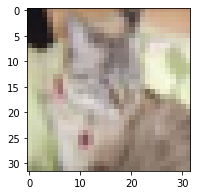

In [3]:
fig = plt.figure(figsize=[3,3])
plt.imshow(np.transpose(dat[10, :, :, :], (1,2,0)))
plt.show()

# Question 1
Below we first implement non-linearities.

In [4]:
def relu(img):
    return np.maximum(0,img)

def sigmoid(img):
    return 1/1+np.exp(-img)

def tanh(img):
    return np.tanh(img)

def prelu(img, param):
    return np.maximum(img, param*img)

Below we implement the convolution function as required.

In [5]:
def convolution(img, kernel, stride, non_linearity, padding=0, prelu_param=None):
    K, _, _ = np.shape(kernel)
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([(H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    kernel = kernel[::-1, ::-1, :]

    horizontal_flip = img[:, :, ::-1]
    vertical_flip = img[:, ::-1, :]
    full_flip = img[:, ::-1, ::-1]
    padded_img = np.zeros([C, H+2*padding, W+2*padding])
    padded_img[:, padding:H+padding, padding:W+padding] = img #center
    padded_img[:, 0:padding, 0:padding] = full_flip[:, -padding:, -padding:] #top left corner
    padded_img[:, 0:padding, padding:W+padding] = vertical_flip[:, -padding:, :] #upper horizontal
    padded_img[:, padding:H+padding, 0:padding] = horizontal_flip[:, :, -padding:] #left vertical
    padded_img[:, -padding:, 0:padding] = full_flip[:, 0:padding, -padding:] #lower left corner
    padded_img[:, 0:padding, -padding:] = full_flip[:, -padding:, 0:padding] #upper right corner
    padded_img[:, -padding:, padding:W+padding] = vertical_flip[:, 0:padding, :] #lower horizontal
    padded_img[:, padding:H+padding, -padding:] = horizontal_flip[:, :, 0:padding] #right vertical
    padded_img[:, -padding:, -padding:] = full_flip[:, 0:padding, 0:padding] #lower right corner

    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m,n] = np.sum(padded_img[:, stride*m:stride*m+K, stride*n:stride*n+K]*kernel)
    if prelu_param is not None: return prelu(out_, prelu_param)
    return non_linearity(out_)

The convolution function has been tested below with stride = 2 and padding = 1. All 4 non-linearities have been tested in the order relu, sigmoid, tanh, prelu.

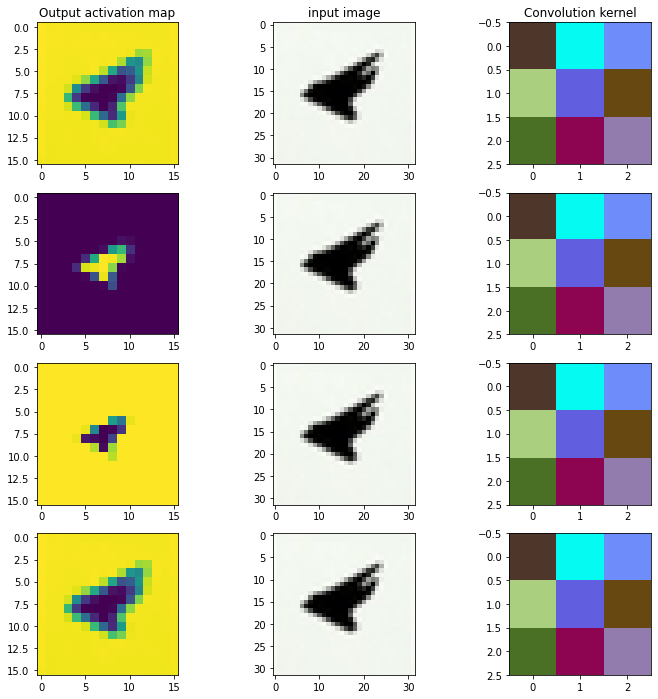

In [6]:
kern = np.random.uniform(0,1,[3, 3, 3])
a = convolution(dat[2, :, :, :], kern, 2, relu, 1)

fig, ax = plt.subplots(4,3, figsize=(12,12))
ax[0,0].imshow(a)
ax[0,0].set_title("Output activation map")

ax[0,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[0,1].set_title("input image")

ax[0,2].imshow(kern)
ax[0,2].set_title("Convolution kernel")

a = convolution(dat[2, :, :, :], kern, 2, sigmoid, 1)
ax[1,0].imshow(a)
ax[1,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[1,2].imshow(kern)

a = convolution(dat[2, :, :, :], kern, 2, tanh, 1)
ax[2,0].imshow(a)
ax[2,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[2,2].imshow(kern)

a = convolution(dat[2, :, :, :], kern, 2, prelu, 1, 0.5)
ax[3,0].imshow(a)
ax[3,1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
ax[3,2].imshow(kern)

plt.show()

# Question 2
Below we define the pool function and then define the pooling operations max_pool and avg_pool.

In [7]:
def pool(inp, pool_func, size, stride):
    H, W = np.shape(inp)
    out_ = np.zeros([(H-size)//stride+1, (W-size)//stride+1])
    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m, n] = pool_func(inp[stride*m:stride*m+size, stride*n:stride*n+size])
    return out_

def max_pool(inp):
    return np.max(inp)

def avg_pool(inp):
    return np.mean(inp)

Below we test the pool function with layer size of 3x3=1 and stride=1.

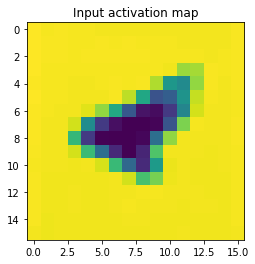

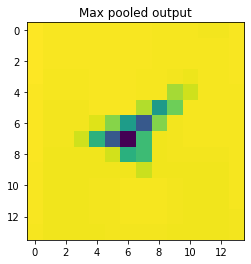

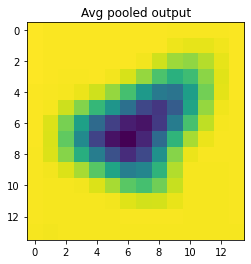

In [8]:
plt.imshow(a)
plt.title("Input activation map")
plt.show()

plt.imshow(pool(a, max_pool, 3, 1))
plt.title("Max pooled output")
plt.show()

plt.imshow(pool(a, avg_pool, 3, 1))
plt.title("Avg pooled output")
plt.show()

# Question 3
Below we implement convolution layer

In [9]:
def convolution_layer(img, kernels, stride, non_linearity, padding=0, prelu_param=None):
    out_channels, K, _, _ = kernels.shape
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([out_channels, (H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    for h in range(out_channels):
        out_[h, :, :] = convolution(img, kernels[h, :, :, :], stride, non_linearity, padding, prelu_param)
    return out_

Below we test the convolution_layer. The size of the output is n_kerns x W x H (10 x 32 x 32). Note that it is not W x H x C as throughout this assignment, I have used the more common NxCxHxW representation of images. Thus it is expected that we get 10x32x32 size for convolution layer output. Also H and W are 32 because in the below, I have used stride=1 and padding=1.

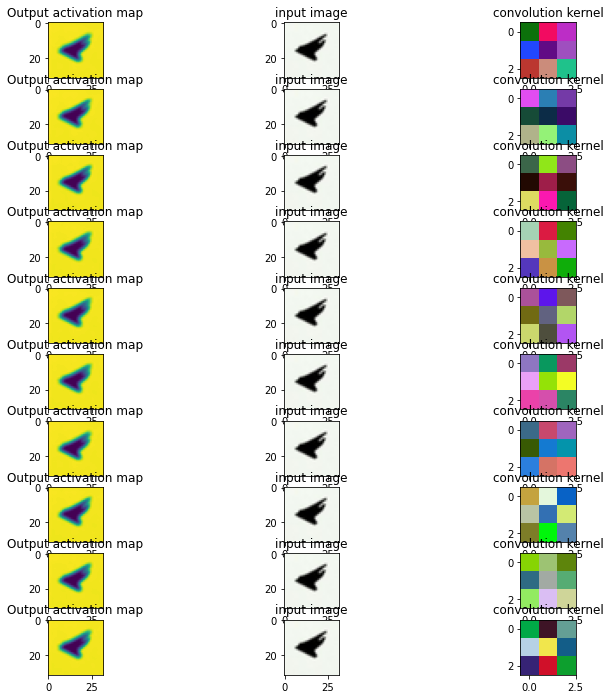

The expected shape of output is 10x32x32 as I have used NxCxHxW convention. The shape of output =  (10, 32, 32)


In [10]:
n_kerns = 10
kerns = np.random.uniform(0, 1, [n_kerns, 3, 3, 3])
a = convolution_layer(dat[2, :, :, :], kerns, 1, relu, 1)
fig, ax = plt.subplots(10, 3, figsize=(12,12))
for i in range(n_kerns):
    ax[i, 0].imshow(a[i, :, :])
    ax[i, 0].set_title("Output activation map")
    ax[i, 1].imshow(np.transpose(dat[2, :, :, :], (1,2,0)))
    ax[i, 1].set_title("input image")
    ax[i, 2].imshow(kerns[i, :, :, :])
    ax[i, 2].set_title("convolution kernel")

plt.show()
print("The expected shape of output is 10x32x32 as I have used NxCxHxW convention. The shape of output = ", np.shape(a))

# Question 4
Below we first implement pooling layer and then test it.

In [11]:
def pooling_layer(inp, pool_func, size, stride):
    C, H, W = np.shape(inp)
    out_ = np.zeros([C, (H-size)//stride+1, (W-size)//stride+1])
    for h in range(C):
        out_[h, :, :] = pool(inp[h, :, :], pool_func, size, stride)
    return out_

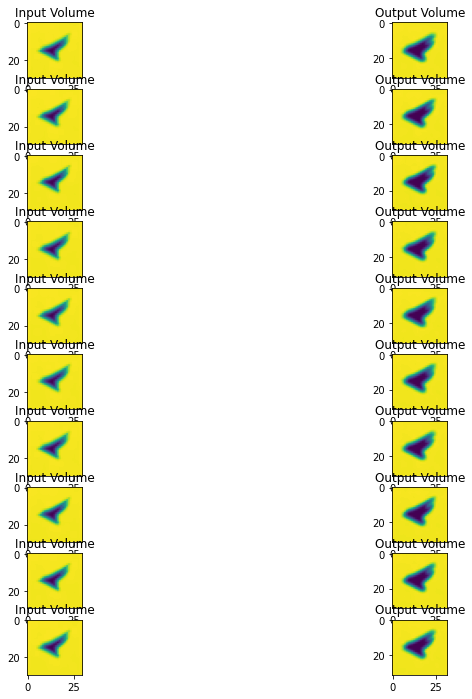

In [12]:
b = pooling_layer(a, max_pool, 3, 1)
fig, ax = plt.subplots(10, 2, figsize=(12,12))
for i in range(b.shape[0]):
    ax[i, 0].imshow(b[i, :, :])
    ax[i, 0].set_title("Input Volume")
    ax[i, 1].imshow(a[i, :, :])
    ax[i, 1].set_title("Output Volume")

plt.show()

# Question 5
Below we implement and test flatten function as required.

In [22]:
def flatten(inp):
    return inp.reshape(-1)

In [24]:
print("Input shape:", b.shape)
print("Output shape:", flatten(b).shape)

Input shape: (10, 30, 30)
Output shape: (9000,)


# Question 6

In [ ]:
def mlp(x, n_hid, hid, non_linearity, out_size):
